Explore the data generated by the big training run on talapas.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# double-output models

Because the classification doesn't go well...

job id 25599241, name `prod3d`, ran for more than 12 days (46 epochs) but best validation loss was after epoch 6. <br>
`Epoch 6: val_loss improved from 0.23528 to 0.23229, saving model to training_data/production_double_N100_trip_lr3_model.hdf5` <br>
`loss: 0.2240 - out_mean_loss: 0.0987 - out_sd_loss: 0.1253 - val_loss: 0.2323 - val_out_mean_loss: 0.1062 - val_out_sd_loss: 0.1261 - lr: 0.0010`

(started job id 25746497, name `prod3s`, to train on single output, the mean dispersal distance, to see how well the model can learn just one thing instead of two. <br>
update: about the same performance, reached a validation loss of 0.10173 in epoch 6 and then stopped improving. haven't predicted with this model but I imagine MRAE would be about the same with such similar validation loss.)

In [21]:
!Rscript pivot_predictions.R production_double_N100_trip_lr3_predictions.csv

In [17]:
longer = pd.read_csv('production_double_N100_trip_lr3_predictions_longer.csv')
longer['relative_resid'] = (longer.predicted - longer.true) / longer.true
longer['Jump kernel'] = np.where(longer.PL_dispersal, 'Power law', 'Gaussian')
longer.head()

,idx,PL_dispersal,sigma,kernel_exponent,variable,true,predicted,LDD_class,RAE,relative_resid,Jump kernel
0,1,False,1.264900,3.60033,mean_distance,1.870990,1.570890,0,0.160396,-0.160396,Gaussian
1,1,False,1.264900,3.60033,sd_distance,0.845858,0.818193,0,0.032706,-0.032706,Gaussian
2,2,False,0.275409,3.88248,mean_distance,0.423423,0.324116,0,0.234534,-0.234534,Gaussian
3,2,False,0.275409,3.88248,sd_distance,0.187941,0.163540,0,0.129834,-0.129834,Gaussian
4,3,False,1.503270,3.04336,mean_distance,2.213490,1.921740,0,0.131805,-0.131805,Gaussian


In [30]:
longer.groupby(['variable', 'Jump kernel'])['relative_resid'].describe()

count      mean       std       min       25%  \
variable      Jump kernel                                                  
mean_distance Gaussian     993.0 -0.110819  0.153185 -0.483701 -0.215471   
              Power law    960.0  0.030039  0.168509 -0.402249 -0.084051   
sd_distance   Gaussian     993.0  0.007906  0.178071 -0.415658 -0.117729   
              Power law    960.0 -0.030951  0.211464 -0.554868 -0.174131   

                                50%       75%       max  
variable      Jump kernel                                
mean_distance Gaussian    -0.128991 -0.019543  0.596995  
              Power law    0.005738  0.126300  0.774967  
sd_distance   Gaussian    -0.014761  0.114071  0.844992  
              Power law   -0.035394  0.100662  1.002542

In [23]:
longer.groupby('variable')['RAE'].describe()

,count,mean,std,min,25%,50%,75%,max
variable,,,,,,,,
mean_distance,1953.0,0.145211,0.107096,0.000068,0.063173,0.126138,0.206249,0.774967
sd_distance,1953.0,0.154330,0.121477,0.000046,0.060501,0.125476,0.222263,1.002542


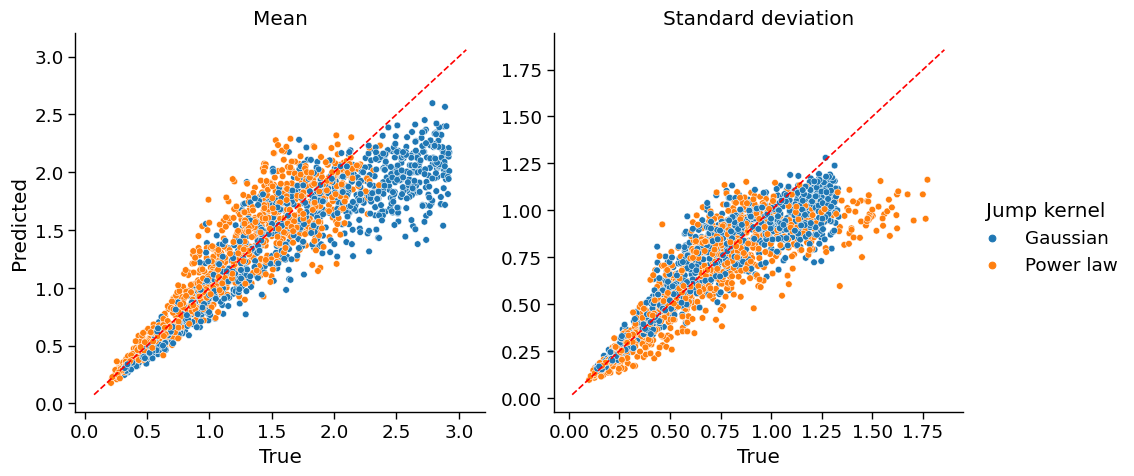

In [23]:
with sns.plotting_context('paper', font_scale=1.5):
    g = sns.relplot(data=longer, x='true', y='predicted', hue='Jump kernel', col='variable', facet_kws={'sharex':False, 'sharey':False})
    g.axes[0,0].set_title('Mean')
    g.axes[0,1].set_title('Standard deviation')
    g.set_axis_labels('True', 'Predicted')
    for ax in g.axes.flatten():
        lims = ax.get_xlim()
        ax.plot(lims, lims, '--r');
#     g.fig.savefig('/Users/nathanvilliger/Oregon/Research/After_Comps/dissertation_NV/4_ML/jointpreds.pdf', bbox_inches='tight')

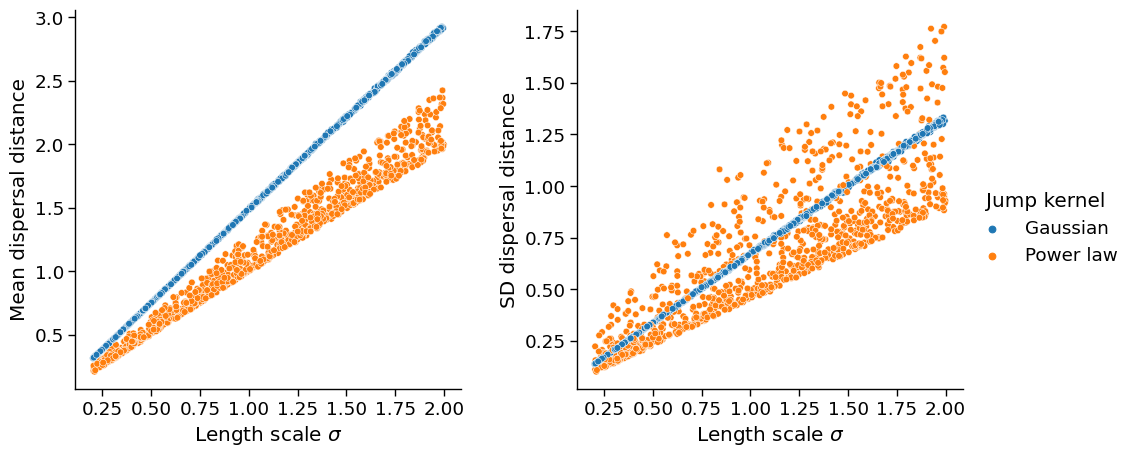

In [30]:
with sns.plotting_context('paper', font_scale=1.5):
    g = sns.relplot(data=longer, x='sigma', y='true', col='variable', hue='Jump kernel', facet_kws={'sharey':False})
    g.set_xlabels(r'Length scale $\sigma$')
    g.axes[0, 0].set(ylabel='Mean dispersal distance', title='')
    g.axes[0, 1].set(ylabel='SD dispersal distance', title='')
    g.fig.subplots_adjust(wspace=0.3)
#     g.fig.savefig('/Users/nathanvilliger/Oregon/Research/After_Comps/dissertation_NV/4_ML/training_separate.pdf', bbox_inches='tight')

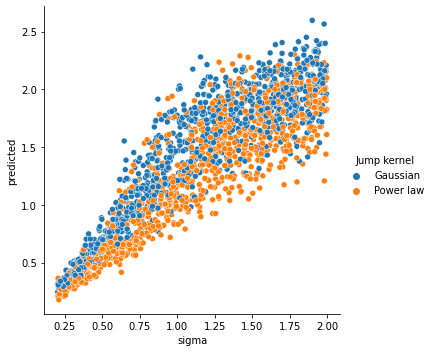

In [37]:
g = sns.relplot(data=longer[longer.variable == 'mean_distance'], x='sigma', y='predicted', hue='Jump kernel');

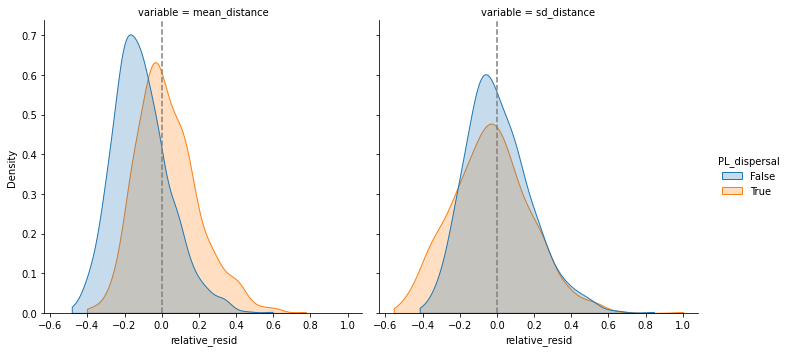

In [26]:
g = sns.displot(data=longer, x='relative_resid', hue='PL_dispersal', col='variable', kind='kde', cut=0, fill=True)
g.refline(x=0);

# diversion: summary stats from genotype matrix rather than tree sequences

In [31]:
df = pd.read_csv('combined_summary_wstats.csv')
df['Jump kernel'] = np.where(df.PL_dispersal, 'Power law', 'Gaussian')
df.head()

,idx,seed,PL_dispersal,capacity,habitat_width,sigma,kernel_exponent,mean_distance,sd_distance,max_distance,excess_kurtosis,LDD_class,IBD_R2,IBD_slope,IBD_Nw,Jump kernel
0,1,17812,False,10,50,1.264900,3.60033,1.870990,0.845858,6.39935,0.440132,0,0.000439,0.006546,152.773260,Gaussian
1,2,48030,False,10,50,0.275409,3.88248,0.423423,0.187941,1.38445,0.412625,0,0.015701,0.084386,11.850254,Gaussian
2,3,6040,False,10,50,1.503270,3.04336,2.213490,1.001790,7.85765,0.536039,0,0.000709,-0.005635,-177.469304,Gaussian
3,4,35725,False,10,50,0.388653,4.62831,0.587767,0.262143,1.90761,0.482867,0,0.027602,0.091853,10.886996,Gaussian
4,5,58895,True,10,50,0.648202,4.53829,0.659278,0.305019,6.03531,6.271720,1,0.000737,0.010829,92.343950,Power law


In [4]:
df.describe()[['IBD_R2', 'IBD_slope', 'IBD_Nw']]

,IBD_R2,IBD_slope,IBD_Nw
count,1.953000e+03,1953.000000,1953.000000
mean,5.532658e-03,0.025035,64.511413
std,9.227256e-03,0.042320,2016.641114
min,5.784803e-09,-0.031312,-46238.334891
25%,3.631215e-04,0.002599,10.074533
50%,1.769163e-03,0.011724,43.715421
75%,6.074630e-03,0.028986,102.379281
max,8.956958e-02,0.425203,53374.328994


In [5]:
%%R -i df 
t.test(IBD_slope ~ PL_dispersal, data=df)


	Welch Two Sample t-test

data:  IBD_slope by PL_dispersal
t = -4.9042, df = 1755, p-value = 1.025e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.013140275 -0.005632542
sample estimates:
mean in group FALSE  mean in group TRUE 
         0.02042123          0.02980763 



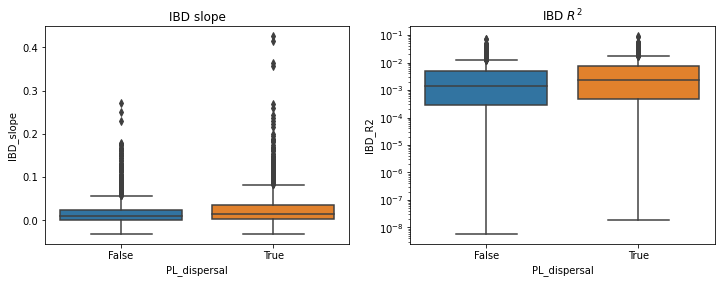

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(data=df, x='PL_dispersal', y='IBD_slope', ax=axs[0])
axs[0].set_title('IBD slope')

sns.boxplot(data=df, x='PL_dispersal', y='IBD_R2', ax=axs[1])
axs[1].set_yscale('log')
axs[1].set_title(r'IBD $R^2$');

Wait, MORE isolation by distance in simulations with power law dispersal? Shouldn't it be less because of more spatial mixing in PL sims?

Do a dummy check. How does IBD change with increasing dispersal in Gaussian sims?

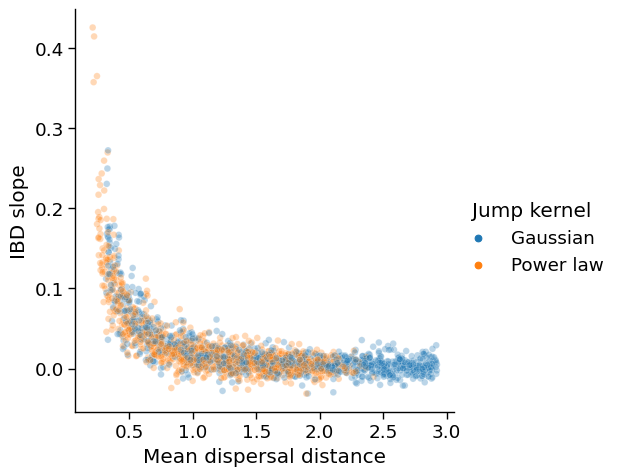

In [33]:
with sns.plotting_context('paper', font_scale=1.5):
    g = sns.relplot(data=df, x='mean_distance', y='IBD_slope', hue='Jump kernel', kind='scatter', alpha=0.3)
    g.set_axis_labels('Mean dispersal distance', 'IBD slope')
#     g.fig.savefig('/Users/nathanvilliger/Oregon/Research/After_Comps/dissertation_NV/4_ML/IBD_vs_disprate.pdf', bbox_inches='tight')

# diversion: summary stats from tree sequences

In [2]:
df = pd.read_csv('combined_summary_wstats.csv')
df.head()

,idx,seed,PL_dispersal,capacity,habitat_width,sigma,kernel_exponent,mean_distance,sd_distance,max_distance,excess_kurtosis,LDD_class,pi,Tajimas_D
0,1,17812,False,10,50,1.264900,3.60033,1.870990,0.845858,6.39935,0.440132,0,0.020181,NaN
1,2,48030,False,10,50,0.275409,3.88248,0.423423,0.187941,1.38445,0.412625,0,0.020771,-0.383393
2,3,6040,False,10,50,1.503270,3.04336,2.213490,1.001790,7.85765,0.536039,0,0.021005,NaN
3,4,35725,False,10,50,0.388653,4.62831,0.587767,0.262143,1.90761,0.482867,0,0.020745,-0.139110
4,5,58895,True,10,50,0.648202,4.53829,0.659278,0.305019,6.03531,6.271720,1,0.019681,-1.939990


**Why so many NaNs in the Tajima's D calculations?**

In [16]:
np.sum(np.isnan(df.Tajimas_D))

618

In [4]:
len(df)

1953

In [9]:
df.groupby('PL_dispersal')['pi'].describe()

,count,mean,std,min,25%,50%,75%,max
PL_dispersal,,,,,,,,
False,993.0,0.018794,0.002202,0.012191,0.017400,0.018692,0.020134,0.027600
True,960.0,0.019133,0.002136,0.012819,0.017692,0.018960,0.020611,0.025986


In [10]:
df.groupby('PL_dispersal')['Tajimas_D'].describe()

,count,mean,std,min,25%,50%,75%,max
PL_dispersal,,,,,,,,
False,733.0,-0.976758,1.578033,-13.628169,-1.465287,-0.235153,-0.158393,-0.015345
True,602.0,-2.172791,2.063342,-19.955833,-2.415975,-1.793954,-1.332098,-0.038671


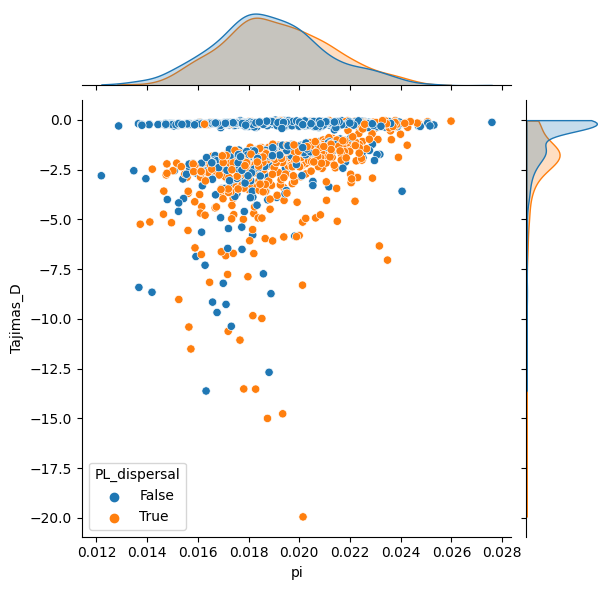

In [8]:
g = sns.jointplot(data=df, x='pi', y='Tajimas_D', hue='PL_dispersal', marginal_kws={'cut':0});

---

# <font color=red> Old and sometimes messy stuff below here

# Back to an original triple-output model

Now the LDD classification:

Classification accuracy: 0.593


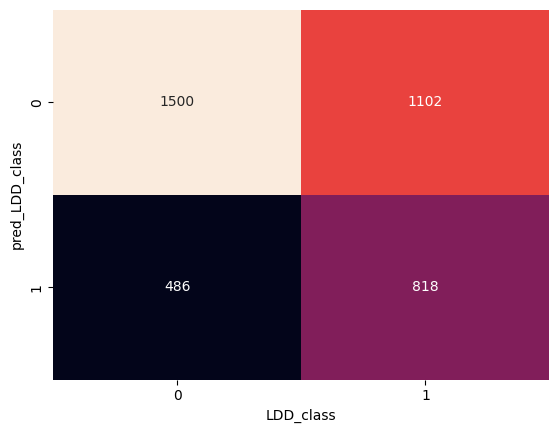

In [48]:
print(f'Classification accuracy: {np.mean(longer.LDD_class == longer.pred_LDD_class):.3f}')
%R -i longer -o confusion ; suppressMessages(library(dplyr)); confusion <- longer %>% count(LDD_class, pred_LDD_class)
# confusion
sns.heatmap(data=confusion.pivot(index='pred_LDD_class', columns='LDD_class', values='n'), annot=True, fmt='.0f', cbar=False);

# the training data

In [15]:
df = pd.read_csv('combined_summary.csv')
df['Jump kernel'] =  np.where(df.PL_dispersal, 'Power law', 'Gaussian')  
df.head()

,idx,seed,PL_dispersal,capacity,habitat_width,sigma,kernel_exponent,mean_distance,sd_distance,max_distance,excess_kurtosis,LDD_class,Jump kernel
0,1,17812,False,10,50,1.264900,3.60033,1.870990,0.845858,6.39935,0.440132,0,Gaussian
1,2,48030,False,10,50,0.275409,3.88248,0.423423,0.187941,1.38445,0.412625,0,Gaussian
2,3,6040,False,10,50,1.503270,3.04336,2.213490,1.001790,7.85765,0.536039,0,Gaussian
3,4,35725,False,10,50,0.388653,4.62831,0.587767,0.262143,1.90761,0.482867,0,Gaussian
4,5,58895,True,10,50,0.648202,4.53829,0.659278,0.305019,6.03531,6.271720,1,Power law


In [4]:
len(df)

1953

In [6]:
%%R -i df 
table(df$PL_dispersal)


FALSE  TRUE 
  993   960 


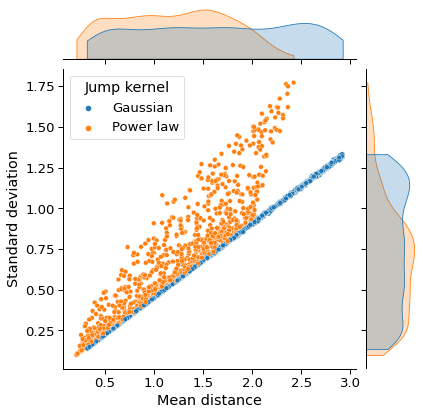

In [19]:
with sns.plotting_context('paper', font_scale=1.5):
    g = sns.jointplot(data=df, x='mean_distance', y='sd_distance', hue='Jump kernel', marginal_kws={'cut':0})
    g.set_axis_labels(xlabel='Mean distance', ylabel='Standard deviation');
#     g.savefig('training_phase.pdf')

Number of simulations and classifications:

In [8]:
print(len(df), 'simulations')
print(f'{(np.mean(df.PL_dispersal) * 100):.1f}% use PL jump kernel')
print(f'proportion of PL jump kernel sims classified as YES LDD: {np.mean(df[df.PL_dispersal].LDD_class):.3f}')
print(f'proportion of Gaussian jump kernel sims classified as NO LDD: {np.mean(df[~df.PL_dispersal].LDD_class == 0):.3f}')

1953 simulations
49.2% use PL jump kernel
proportion of PL jump kernel sims classified as YES LDD: 1.000
proportion of Gaussian jump kernel sims classified as NO LDD: 1.000


Explore parameters, first Gaussian and then PL. What range of sigma values were covered by the Gaussian simulations?

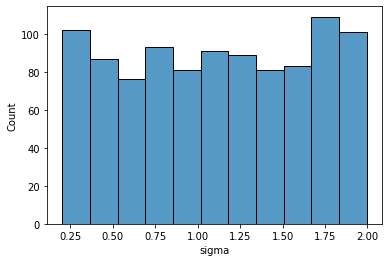

In [11]:
sns.histplot(df[~df.PL_dispersal].sigma);

And what range of sigma values and kernel exponents were covered by the simulations that used power law jump kernels?

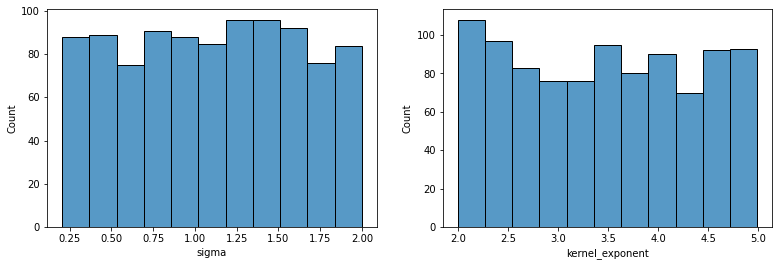

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(13, 4))
sns.histplot(df[df.PL_dispersal].sigma, ax=axs[0])
sns.histplot(df[df.PL_dispersal].kernel_exponent, ax=axs[1]);

---

# Single output model predictions

Working towards choosing good learning rate, batch size, repeated samples. Here's the first try with lr=0.01, bs=50, reps=50:

,epoch,loss,lr,val_loss
2,2,0.679449,0.01,0.602118


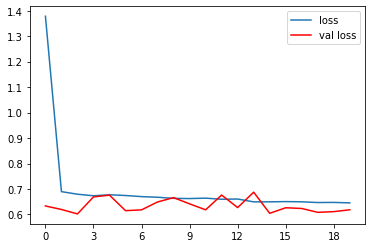

In [13]:
df = pd.read_csv('N10_gpu_single_out_history.csv')
display(df[df.val_loss == np.min(df.val_loss)])

plt.plot(df.epoch, df.loss, label='loss')
plt.plot(df.epoch, df.val_loss, 'r', label='val loss')
plt.xticks(range(0, 19, 3))
plt.legend();

Now decrease batch size to 10:

,epoch,loss,lr,val_loss
14,14,0.792439,0.01,0.610809


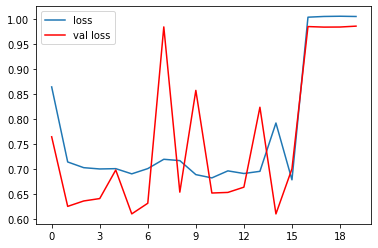

In [12]:
df = pd.read_csv('N10_single_out_smbatch_history.csv')
display(df[df.val_loss == np.min(df.val_loss)])

plt.plot(df.epoch, df.loss, label='loss')
plt.plot(df.epoch, df.val_loss, 'r', label='val loss')
plt.xticks(range(0, 19, 3))
plt.legend();

Increase repeated samples to 100 relative to original params:

,epoch,loss,lr,val_loss
11,11,0.644098,0.01,0.649432


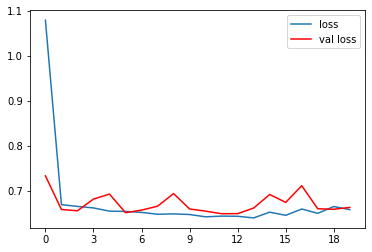

In [11]:
df = pd.read_csv('N10_single_out_msamps_history.csv')
display(df[df.val_loss == np.min(df.val_loss)])

plt.plot(df.epoch, df.loss, label='loss')
plt.plot(df.epoch, df.val_loss, 'r', label='val loss')
plt.xticks(range(0, 19, 3))
plt.legend();

,epoch,loss,lr,val_loss,type
2,2,0.679449,0.01,0.602118,baseline
14,14,0.792439,0.01,0.610809,smaller batches
11,11,0.644098,0.01,0.649432,higher reps


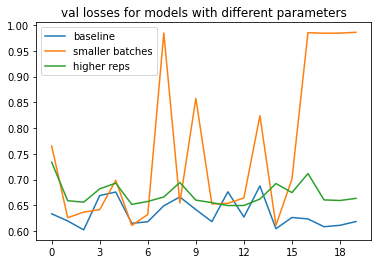

In [18]:
types = ['baseline', 'smaller batches', 'higher reps']
fnames = ['N10_gpu_single_out_history.csv', 'N10_single_out_smbatch_history.csv', 'N10_single_out_msamps_history.csv']
best = []
for typ, f in zip(types, fnames):
    df = pd.read_csv(f)
    df['type'] = typ
    best.append(df[df.val_loss == np.min(df.val_loss)])
    plt.plot(df.epoch, df.val_loss, label=f'{typ}')
plt.title('val losses for models with different parameters')
plt.xticks(range(0, 19, 3))
plt.legend();

display(pd.concat(best))

Hmm... everything is very bad. Maybe I should try *decreasing* the learning rate? Here are predictions from the best model:

In [10]:
preds = pd.read_csv('N10_gpu_single_out_predictions.csv')
MRAE = np.mean(np.abs(preds.pred_mean_distance - preds.mean_distance) / preds.mean_distance)
print(f'MRAE: {MRAE:.3f}')
preds.head()

MRAE: 0.379


,idx,seed,PL_dispersal,capacity,habitat_width,sigma,kernel_exponent,mean_distance,sd_distance,max_distance,excess_kurtosis,LDD_class,pred_mean_distance
0,1,17812,False,10,50,1.264900,3.60033,1.870990,0.845858,6.39935,0.440132,0,1.731134
1,2,48030,False,10,50,0.275409,3.88248,0.423423,0.187941,1.38445,0.412625,0,0.387030
2,3,6040,False,10,50,1.503270,3.04336,2.213490,1.001790,7.85765,0.536039,0,1.683846
3,4,35725,False,10,50,0.388653,4.62831,0.587767,0.262143,1.90761,0.482867,0,0.894630
4,5,58895,True,10,50,0.648202,4.53829,0.659278,0.305019,6.03531,6.271720,1,1.479545


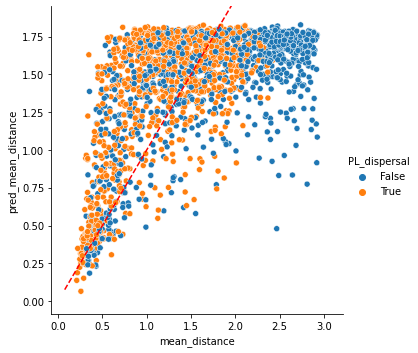

In [11]:
g = sns.relplot(data=preds, x='mean_distance', y='pred_mean_distance', hue='PL_dispersal')
lims = g.ax.get_xlim()
g.ax.plot(lims, lims, '--r');
g.ax.set_ylim(top=1.95);